In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import matplotlib.pyplot as plt
import h5py
import numpy as np
import get_xyz
import constants
from pathlib import Path
import hdf5plugin
import add_geometry_streaks
import scipy.constants as sc
import scipy.ndimage
import pickle

from scipy.interpolate import griddata
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
scan_info['bernina.cbd.sample_y.readback'].keys()

dict_keys(['SARES20-MCS3:MOT_2.RBV'])

In [14]:
run = 227
sample_name = 'Vit-B12-recryst-1'

# get x-y coordinates vs pid
scan_fnam = f'{constants.beamtime_dir}/raw/run{run:>04}/aux/scan_monitor.pkl'

scan_info = pickle.load(open(scan_fnam, 'rb'))

# timestamps for x y motor positions
a = scan_info['bernina.cbd.sample_x.readback']['SARES20-MCS3:MOT_1.RBV']
tx = np.array([v['timestamp_local'] for v in a])
x = np.array([v['value'] for v in a]) * 1e-3

a = scan_info['bernina.cbd.sample_y.readback']['SARES20-MCS3:MOT_2.RBV']
y = np.array([v['value'] for v in a]) * 1e-3
ty = np.array([v['timestamp_local'] for v in a])

a = scan_info['pulse_id']['SLAAR21-LTIM01-EVR0:RX-PULSEID']
tpid = np.array([v['timestamp_local'] for v in a])
pid = np.array([v['value'] for v in a])

x_pid = np.interp(tpid, tx, x)
y_pid = np.interp(tpid, ty, y)

# get pulse ids of streaks
fnam = Path(constants.work) / f'streaks/streaks_run{run:>04}.h5'
with h5py.File(fnam, 'r') as f:
    print(f.keys())
    pid_s = np.squeeze(f['pulse_id'][()])
    
    # streaks = f['fs0_ss0_fs1_ss1_slab'][()]
    # x0, y0, x1, y1 = streaks.T
    # dx = x1 - x0
    # dy = y1 - y0
    # length = (dx**2 + dy**2)**0.5
    
    counts = f['counts'][()] #/ length

# counts_pid = np.interp(pid, pid_s, counts)

##check if masked pid and unique pid_s have the same order(should be the case as both are strictly assending)
#print(pid[mask]==np.unique(pid_s))

<KeysViewHDF5 ['counts', 'file_index', 'file_name', 'fs0_ss0_fs1_ss1_im', 'fs0_ss0_fs1_ss1_slab', 'pulse_id']>


In [15]:
# create a mask for which pulse ids (pid) corresponded to an actual used pulses (pid_s)
pid_s_unique, pid_ind = np.unique(pid_s, return_inverse=True)

counts_pid_s = np.bincount(pid_ind, weights=counts)              
# t0 = time.time()
# mask = np.array([p in pid_s_unique for p in pid])
# t1 = time.time()
#mask = np.isin(pid,pid_s_unique)#,assume_unique=True
pid_pid_s_u = np.searchsorted(pid, pid_s_unique)
# t2 = time.time()
# mask = is_in_sorted(pid,pid_s_unique)
# t3 = time.time()
# print('array: ',t1-t0, 'isin: ',t2-t1, 'is_in_sorted: ',t3-t2)

In [16]:
aspect_ratio = np.max((y_pid)-np.min(y_pid))/(np.max(x_pid)-np.min(x_pid))

In [17]:
# scatter plot: it is sorted accoring to counts, so that the most intense scatter plots are on top
"""
plt.figure(figsize=(20,20))
idx = np.array(counts_pid_s).argsort()
plt.scatter(1e3*x_pid[mask][idx], 1e3*y_pid[mask][idx], c=np.clip(np.array(counts_pid_s)[idx],a_min=0,a_max=np.nanpercentile(counts,99.95)),cmap='plasma',s=0.01)
plt.gca().set_aspect('equal')
plt.colorbar(label='summed streak intensity',fraction=aspect_ratio/20)
plt.gca().set_xlabel('sample x (mm)')
plt.gca().set_ylabel('sample y (mm)')
plt.title('STXM of %s %s'%(run,sample_name))
plt.savefig('STXM/STXM_run_%s_%s_intensity_scatter.png'%(run,sample_name))
# plt.colorbar(label='summed streak intensity')
plt.show()
"""

"\nplt.figure(figsize=(20,20))\nidx = np.array(counts_pid_s).argsort()\nplt.scatter(1e3*x_pid[mask][idx], 1e3*y_pid[mask][idx], c=np.clip(np.array(counts_pid_s)[idx],a_min=0,a_max=np.nanpercentile(counts,99.95)),cmap='plasma',s=0.01)\nplt.gca().set_aspect('equal')\nplt.colorbar(label='summed streak intensity',fraction=aspect_ratio/20)\nplt.gca().set_xlabel('sample x (mm)')\nplt.gca().set_ylabel('sample y (mm)')\nplt.title('STXM of %s %s'%(run,sample_name))\nplt.savefig('STXM/STXM_run_%s_%s_intensity_scatter.png'%(run,sample_name))\n# plt.colorbar(label='summed streak intensity')\nplt.show()\n"

In [18]:
#map added counts to pid
counts_pid = np.zeros_like(pid)
#counts_pid[mask] = counts_pid_s
counts_pid[pid_pid_s_u] = counts_pid_s

In [19]:
#interpolate the results
grid_x, grid_y = np.mgrid[min(y_pid):max(y_pid):complex(np.round(1000*aspect_ratio)),min(x_pid):max(x_pid):1000j]
grid_counts = griddata((y_pid,x_pid),counts_pid,(grid_x,grid_y),method='linear')

In [20]:
'STXM/STXM_run_%s_%s_intensity.png'%(run,sample_name)

'STXM/STXM_run_227_Vit-B12-recryst-1_intensity.png'

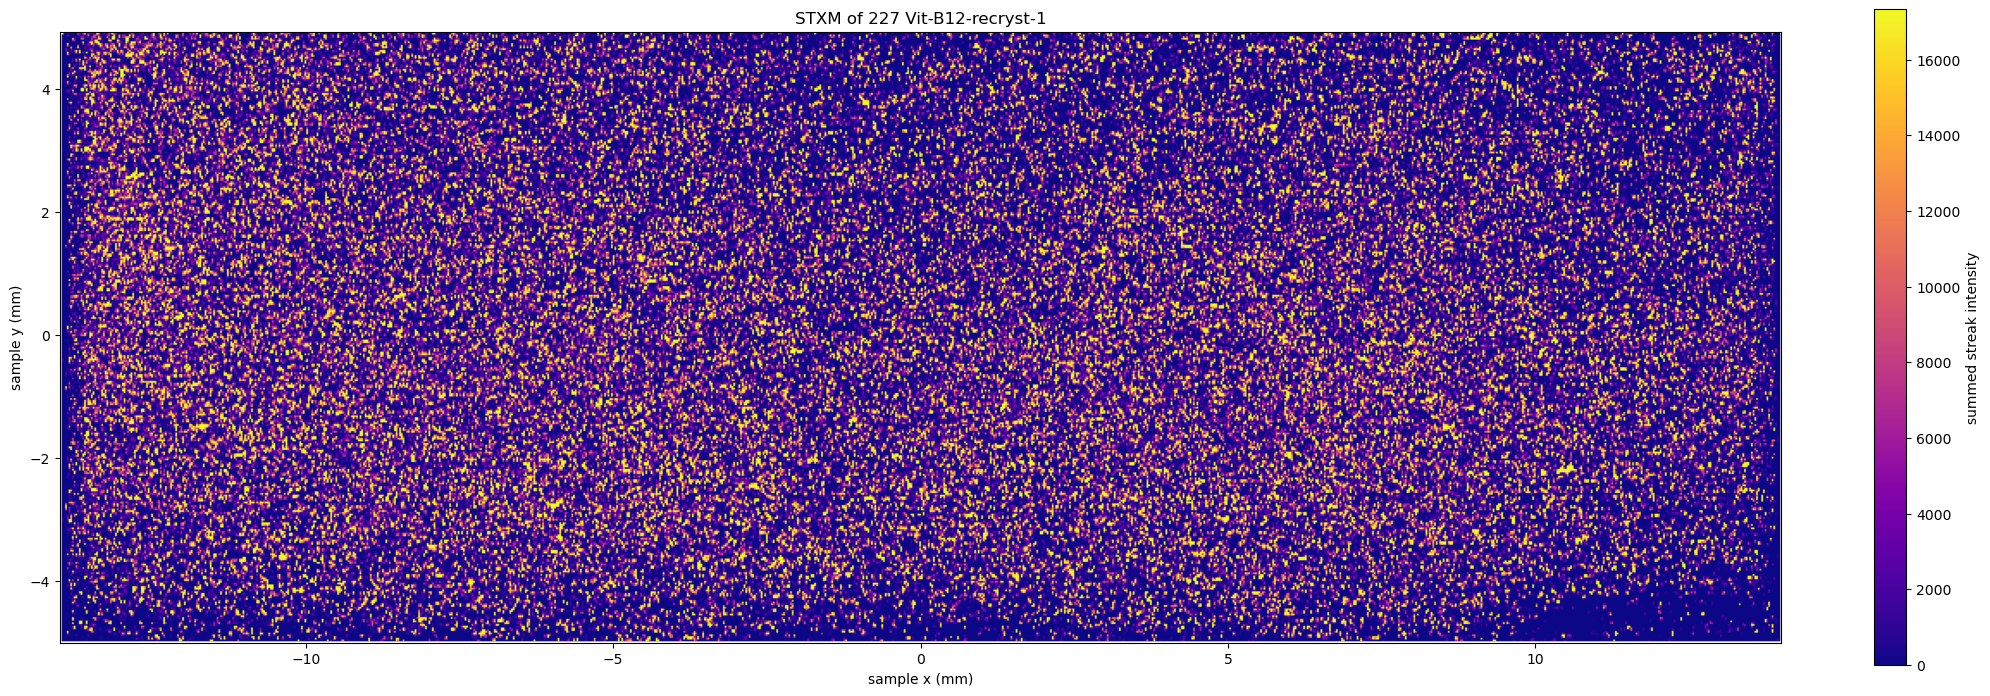

In [21]:
#create a heatmap
fig, ax = plt.subplots()
vmax = np.nanpercentile(counts,99.9)
im = ax.imshow(grid_counts,extent=(1e3*min(x_pid),1e3*max(x_pid),1e3*min(y_pid),1e3*max(y_pid)),origin='lower', cmap='plasma',aspect='equal',vmin=0,vmax=vmax)
plt.colorbar(im, label='summed streak intensity',fraction=aspect_ratio/20)
ax.set_xlabel('sample x (mm)')
ax.set_ylabel('sample y (mm)')
ax.set_title('STXM of %s %s'%(run,sample_name))
fig.set_size_inches(20, aspect_ratio * 20)
fig.set_tight_layout(True)
plt.savefig('STXM/STXM_run_%s_%s_intensity.png'%(run,sample_name))
plt.show()

In [40]:
#same procedure with number of streaks
nStreaks_pid = np.zeros_like(pid)
binc = np.bincount(pid_s)
nStreaks_pid_s = [binc[pi] for pi in np.unique(pid_s)]

In [ ]:
#scatter
# idx = np.array(nStreaks_pid_s).argsort()
plt.figure(figsize=(20,20))
idx = np.array(counts_pid_s).argsort()
plt.scatter(1e3*x_pid[mask][idx], 1e3*y_pid[mask][idx], c=np.clip(np.array(nStreaks_pid_s)[idx],a_min=0,a_max=np.nanpercentile(nStreaks_pid_s,98)),cmap='plasma',s=0.01)
plt.colorbar(label='number of streaks',fraction=aspect_ratio/20)
plt.gca().set_aspect('equal')
# plt.colorbar(sc)#,label='summed streak intensity',fraction=aspect_ratio/20)
plt.gca().set_xlabel('sample x (mm)')
plt.gca().set_ylabel('sample y (mm)')
plt.title('STXM of %s %s'%(run,sample_name))
plt.savefig('STXM/STXM_run_%s_%s_streaks_scatter.png'%(run,sample_name))
plt.show()

In [ ]:
#map added counts to pid
nStreaks_pid = np.zeros_like(pid)
nStreaks_pid[mask] = nStreaks_pid_s

In [ ]:
#interpolate the results
grid_streaks = griddata((y_pid,x_pid),nStreaks_pid,(grid_x,grid_y),method='linear')

In [ ]:
#create a heatmap
plt.figure(figsize=(20,20))
plt.imshow(grid_streaks,extent=(1e3*min(x_pid),1e3*max(x_pid),1e3*min(y_pid),1e3*max(y_pid)),origin='lower', cmap='plasma',aspect='equal',vmin=0,vmax=np.nanpercentile(nStreaks_pid_s,98))
plt.colorbar(label='number of streaks',fraction=aspect_ratio/20)
plt.gca().set_xlabel('sample x (mm)')
plt.gca().set_ylabel('sample y (mm)')
plt.title('STXM of %s %s'%(run,sample_name))
plt.savefig('STXM/STXM_run_%s_%s_streaks'%(run,sample_name))
plt.show()

In [ ]:
# # imshow
# fig, ax = plt.subplots()
# fig.set_size_inches(20, 20)
# H, bx, by = np.histogram2d(1e3*x_pid, 1e3*y_pid, weights=counts_pid, bins=[100, int( 0.5 * len(ty))], density=True)
# im = ax.imshow(H.T, extent=[bx[0], bx[-1], by[0], by[-1]], vmin=np.percentile(H, 1), vmax=np.percentile(H, 97), aspect='equal', interpolation='none')
# ax.set_xlabel('sample x (mm)')
# ax.set_ylabel('sample y (mm)')
# plt.show()

In [ ]:
# nStreaks_pid[mask] = nStreaks_pid_s

# fig, ax = plt.subplots()
# fig.set_size_inches(20, 20)
# H, bx, by = np.histogram2d(1e3*x_pid, 1e3*y_pid, weights=nStreaks_pid, bins=[100, int( 0.5 * len(ty))], density=True)
# im = ax.imshow(H.T, extent=[bx[0], bx[-1], by[0], by[-1]], vmin=np.percentile(H, 1), vmax=np.percentile(H, 99), aspect='equal', interpolation='none')
# ax.set_xlabel('sample x (mm)')
# ax.set_ylabel('sample y (mm)')
# plt.show()

In [ ]:
plt.plot(x_pid, y_pid)

In [ ]:
a = scan_info['bernina.cbd.sample_x.readback']['SARES20-MCS3:MOT_1.RBV']
tx = np.array([v['timestamp_local'] for v in a])

a = scan_info['bernina.cbd.sample_y.readback']['SARES20-MCS3:MOT_2.RBV']
ty = np.array([v['timestamp_local'] for v in a])

In [ ]:
y_pid

In [ ]:
!pwd